In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
import torch.distributions as dist
import os
import numpy as np
import errno
import os
import PIL
from functools import reduce
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm


In [53]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

class FashionMNISTEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        hidden_dim=256
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(128, hidden_dim, 4, 1),
            nn.ReLU(True),
            View((-1, hidden_dim*1*1)),
            nn.Linear(hidden_dim, z_dim*2),
        )

        self.locs = nn.Linear(hidden_dim, z_dim)
        self.scales = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        hidden = self.encoder(x)
        return hidden[:, :self.z_dim], torch.clamp(F.softplus(hidden[:, self.z_dim:]), min=1e-3)


class FashionMNISTDecoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        hidden_dim=256
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            View((-1, hidden_dim, 1, 1)),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, 128, 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )



    def forward(self, z):
        return self.decoder(z)

class Classifier(nn.Module):
    def __init__(self, z_dim, classes):
        super(Classifier, self).__init__()
        h_dim = 500
        self.classifier = nn.Sequential(
            nn.Linear(z_dim, classes)
        )

    def forward(self, x):
        return self.classifier(x)

class ConditionalPrior(nn.Module):
    def __init__(self, z_dim, classes):
        super(ConditionalPrior, self).__init__()
        h_dim = 500
        self.locs = nn.Linear(classes, z_dim)
        self.scales = nn.Linear(classes, z_dim)

    def forward(self, x):
        return self.locs(x), torch.clamp(F.softplus(self.scales(x)), min=1e-3)

#Utility Functions

In [54]:
def compute_kl(locs_q, scale_q, locs_p=None, scale_p=None):
    """
    Computes the KL(q||p)
    """
    if locs_p is None:
        locs_p = torch.zeros_like(locs_q)
    if scale_p is None:
        scale_p = torch.ones_like(scale_q)

    dist_q = dist.Normal(locs_q, scale_q)
    dist_p = dist.Normal(locs_p, scale_p)
    return dist.kl.kl_divergence(dist_q, dist_p).sum(dim=-1)

# Computes the log-likelihood of reconstructed images given the original images
def img_log_likelihood(recon, xs):
        return dist.Laplace(recon, torch.ones_like(recon)).log_prob(xs).sum(dim=(1,2,3))

In [55]:
class CCVAE(nn.Module):
    """
    CCVAE
    """
    def __init__(self, z_dim, num_classes,
                 im_shape, use_cuda, prior_fn):
        super(CCVAE, self).__init__()
        self.z_dim = z_dim
        #self.z_classify = num_classes
        #self.z_style = z_dim - num_classes
        self.z_classify = z_dim
        self.z_style = 0
        self.im_shape = im_shape
        self.use_cuda = use_cuda
        self.num_classes = num_classes
        self.ones = torch.ones(1, self.z_style)
        self.zeros = torch.zeros(1, self.z_style)
        self.y_prior_params = FashionMNISTCached.prior_fn()

        self.encoder = FashionMNISTEncoder(self.z_dim)
        self.decoder = FashionMNISTDecoder(self.z_dim)
        self.classifier = Classifier(z_dim=self.z_dim, classes=self.num_classes)
        self.cond_prior = ConditionalPrior(z_dim=self.z_dim, classes=self.num_classes)

        if self.use_cuda:
            self.ones = self.ones.cuda()
            self.zeros = self.zeros.cuda()
            self.y_prior_params = self.y_prior_params.cuda()
            self.cuda()

    def unsup(self, x):
        bs = x.shape[0]
        #inference
        post_params = self.encoder(x)
        z = dist.Normal(*post_params).rsample()
        zc, zs = z.split([self.z_classify, self.z_style], 1)
        qyzc = dist.Categorical(logits=self.classifier(zc))
        y = qyzc.sample()
        log_qy = qyzc.log_prob(y).sum(dim=-1)

        # compute kl
        y = F.one_hot(y, num_classes=self.num_classes).float()
        locs_p_zc, scales_p_zc = self.cond_prior(y)
        prior_params = (torch.cat([locs_p_zc, self.zeros.expand(bs, -1)], dim=1),
                        torch.cat([scales_p_zc, self.ones.expand(bs, -1)], dim=1))
        kl = compute_kl(*post_params, *prior_params)

        #compute log probs for x and y
        recon = self.decoder(z)
        log_py = dist.Bernoulli(self.y_prior_params.expand(bs, -1)).log_prob(y).sum(dim=-1)
        elbo = (img_log_likelihood(recon, x) + log_py - kl - log_qy).mean()
        return -elbo

    def sup(self, x, y):
        bs = x.shape[0]
        #inference
        post_params = self.encoder(x)
        z = dist.Normal(*post_params).rsample()
        zc, zs = z.split([self.z_classify, self.z_style], 1)
        qyzc = dist.Categorical(logits=self.classifier(zc))
        log_qyzc = qyzc.log_prob(y).sum(dim=-1)

        # compute kl
        y = F.one_hot(y, num_classes=self.num_classes).float()
        locs_p_zc, scales_p_zc = self.cond_prior(y)
        prior_params = (torch.cat([locs_p_zc, self.zeros.expand(bs, -1)], dim=1),
                        torch.cat([scales_p_zc, self.ones.expand(bs, -1)], dim=1))
        #prior_params = (self.zeros.expand(bs, -1), self.ones.expand(bs, -1))
        kl = compute_kl(*post_params, *prior_params)

        #compute log probs for x and y
        recon = self.decoder(z)
        log_py = dist.Bernoulli(self.y_prior_params.expand(bs, -1)).log_prob(y).sum(dim=-1)
        log_qyx = self.classifier_loss(x, y)
        log_pxz = img_log_likelihood(recon, x)

        # we only want gradients wrt to params of qyz, so stop them propogating to qzx
        log_qyzc_ = dist.Bernoulli(logits=self.classifier(zc.detach())).log_prob(y).sum(dim=-1)
        w = torch.exp(log_qyzc_ - log_qyx)
        elbo = (w * (log_pxz - kl - log_qyzc) + log_py + log_qyx).mean()
        return -elbo

    def classifier_loss(self, x, y, k=100):
        """
        Computes the classifier loss.
        """
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.z_classify, self.z_style], -1)
        logits = self.classifier(zc.view(-1, self.z_classify))
        d = dist.Bernoulli(logits=logits)
        y = y.expand(k, -1, -1).contiguous().view(-1, self.num_classes)
        lqy_z = d.log_prob(y).view(k, x.shape[0], self.num_classes).sum(dim=-1)
        lqy_x = torch.logsumexp(lqy_z, dim=0) - np.log(k)
        return lqy_x

    def reconstruct_img(self, x):
        return self.decoder(dist.Normal(*self.encoder(x)).rsample())

    def classifier_acc(self, x, y=None, k=1):
        zc, _ = dist.Normal(*self.encoder(x)).rsample(torch.tensor([k])).split([self.z_classify, self.z_style], -1)
        logits = self.classifier(zc.view(-1, self.z_classify)).view(-1, self.num_classes)
        #y = y.expand(k, -1,-1).contiguous().view(-1, self.num_classes)
        #y = y.expand(k, -1).contiguous()
        preds = torch.softmax(logits, dim=1)
        #acc = (preds.eq(y)).float().mean()
        acc = (torch.max(preds,dim=1).indices.eq(y)).float().mean()
        return acc

    def save_models(self, path='./data'):
        torch.save(self.encoder, os.path.join(path,'encoder.pt'))
        torch.save(self.decoder, os.path.join(path,'decoder.pt'))
        torch.save(self.classifier, os.path.join(path,'classifier.pt'))
        torch.save(self.cond_prior, os.path.join(path,'cond_prior.pt'))

    def accuracy(self, data_loader, *args, **kwargs):
        acc = 0.0
        for (x, y) in data_loader:
            if self.use_cuda:
                x, y = x.cuda(), y.cuda()
            batch_acc = self.classifier_acc(x, y)
            acc += batch_acc
        return acc / len(data_loader)

    def latent_walk(self, images, save_dir):
        #img_1=images[0]
        img_2=images[3]
        img_3=images[20]
        #img_4=images[40]
        latent_2=dist.Normal(*self.encoder(img_2)).sample()
        latent_3=dist.Normal(*self.encoder(img_3)).sample()
        num_points = 8
        interpolated_points = [torch.lerp(latent_2, latent_3, i/(num_points+1)) for i in range(1, num_points+1)]
        img_recon=[]
        for point in interpolated_points:
            img_recon.append(torch.squeeze(self.decoder(point).view(-1, *self.im_shape),dim=1))
        grid_recon = make_grid(img_recon)
        save_image(grid_recon, os.path.join(save_dir, "test.png"))

    def latent_traversal(self, images, save_dir):
        # Select four images for interpolation
        img_1 = images[0]
        img_2 = images[9]
        img_3 = images[11]
        img_4 = images[41]

        # Encode the selected images to obtain latent vectors
        latent_1 = dist.Normal(*self.encoder(img_1)).sample()
        latent_2 = dist.Normal(*self.encoder(img_2)).sample()
        latent_3 = dist.Normal(*self.encoder(img_3)).sample()
        latent_4 = dist.Normal(*self.encoder(img_4)).sample()

        # Perform interpolation between latent vectors for all four corners
        num_points = 8
        interpolated_latents = []
        for i in range(num_points):
            for j in range(num_points):
                alpha = i / (num_points - 1)
                beta = j / (num_points - 1)

                interpolated_latent = (
                    (1 - alpha) * (1 - beta) * latent_1 +
                    alpha * (1 - beta) * latent_2 +
                    (1 - alpha) * beta * latent_3 +
                    alpha * beta * latent_4
                )
                interpolated_latents.append(interpolated_latent)

        # Decode interpolated latent vectors and reconstruct images
        img_recon=[]
        for point in interpolated_latents:
            img_recon.append(torch.squeeze(self.decoder(point).view(-1, *self.im_shape),dim=1))

        # Create a grid of reconstructed images and save it
        grid_recon = make_grid(img_recon, nrow=num_points)
        save_image(grid_recon, os.path.join(save_dir, "interpolation_result_bis.png"))

In [56]:
import errno
import os
import PIL
from functools import reduce
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt

def split_fashionmnist(X, y, sup_frac, validation_num):
    """
    splits FashionMNIST
    """

    # validation set is the last 10,000 examples
    X_valid = X[-validation_num:]
    y_valid = y[-validation_num:]

    X = X[0:-validation_num]
    y = y[0:-validation_num]

    if sup_frac == 0.0:
        return None, None, X, y, X_valid, y_valid

    if sup_frac == 1.0:
        return X, y, None, None, X_valid, y_valid

    split = int(sup_frac * len(X))
    X_sup = X[0:split]
    y_sup = y[0:split]
    X_unsup = X[split:]
    y_unsup = y[split:]

    return X_sup, y_sup, X_unsup, y_unsup, X_valid, y_valid

classes = 10

FashionMNIST_classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle_Boot')

def custom_transform(x):
    return x.float() / 255

class FashionMNISTCached(FashionMNIST):
    # static class variables for caching training data
    classes = 10

    train_data_sup, train_labels_sup = None, None
    train_data_unsup, train_labels_unsup = None, None
    train_data, test_labels = None, None
    prior = torch.ones(1, classes) / classes
    fixed_imgs = None
    fixed_imgs_targets = None
    validation_size = 20000
    data_valid, labels_valid = None, None
    shape = (1, 64, 64)

    def prior_fn():
        return FashionMNISTCached.prior

    def clear_cache():
        FashionMNISTCached.train_data, FashionMNISTCached.test_labels = None, None

    def __init__(self, mode, sup_frac=None, *args, **kwargs):
        super(FashionMNISTCached, self).__init__(train=True if mode in ["sup", "unsup", "valid"] else 'test', *args, **kwargs)
        self.sub_label_inds = [i for i in range(classes)]
        self.mode = mode

        # self.transform = lambda x: (x/255).view(-1)
        self.transform = transforms.Compose([
                transforms.Resize(64),
                transforms.Lambda(custom_transform)
            ])

        assert mode in ["sup", "unsup", "test", "valid"], "invalid train/test option values"

        if mode in ["sup", "unsup", "valid"]:

            if FashionMNISTCached.train_data is None:
                print("Splitting Dataset")

                FashionMNISTCached.train_data = self.data
                FashionMNISTCached.train_targets = self.targets

                FashionMNISTCached.train_data_sup, FashionMNISTCached.train_labels_sup, \
                    FashionMNISTCached.train_data_unsup, FashionMNISTCached.train_labels_unsup, \
                    FashionMNISTCached.data_valid, FashionMNISTCached.labels_valid = \
                    split_fashionmnist(FashionMNISTCached.train_data, FashionMNISTCached.train_targets,
                                 sup_frac, FashionMNISTCached.validation_size)

            if mode == "sup":
                self.data, self.targets = FashionMNISTCached.train_data_sup, FashionMNISTCached.train_labels_sup
                FashionMNISTCached.prior = torch.mean(torch.nn.functional.one_hot(self.targets).float(), dim=0)
            elif mode == "unsup":
                self.data = FashionMNISTCached.train_data_unsup
                # making sure that the unsupervised labels are not available to inference
                self.targets = FashionMNISTCached.train_labels_unsup * np.nan
            else:
                self.data, self.targets = FashionMNISTCached.data_valid, FashionMNISTCached.labels_valid

        else:
            self.data = self.data
            self.targets = self.targets

        # create a batch of fixed images
        if FashionMNISTCached.fixed_imgs is None:
            temp = []
            for i in range(64):
                temp.append(self.transform(self.data[i, None, :, :]))
            FashionMNISTCached.fixed_imgs = torch.stack(temp, dim=0)
                #temp.append([self.transform(self.data[i, None,:,:]),self.targets[i]])
            #FashionMNISTCached.fixed_imgs = temp

        if FashionMNISTCached.fixed_imgs_targets is None:
            temp = []
            for i in range(64):
                temp.append([self.transform(self.data[i, None,:,:]),self.targets[i]])
            FashionMNISTCached.fixed_imgs_targets = temp

    def __getitem__(self, index):

        X = self.transform(self.data[index, None,:,:])

        target = self.targets[index]

        return X, target

    def __len__(self):
        return len(self.data)


def setup_data_loaders(use_cuda, batch_size, sup_frac=1.0, root=None, cache_data=False, **kwargs):
    """
        helper function for setting up pytorch data loaders for a semi-supervised dataset
    :param use_cuda: use GPU(s) for training
    :param batch_size: size of a batch of data to output when iterating over the data loaders
    :param sup_frac: fraction of supervised data examples
    :param cache_data: saves dataset to memory, prevents reading from file every time
    :param kwargs: other params for the pytorch data loader
    :return: three data loaders: (supervised data for training, un-supervised data for training,
                                  supervised data for testing)
    """

    if root is None:
        root = get_data_directory(__file__)
    if 'num_workers' not in kwargs:
        kwargs = {'num_workers': 2, 'pin_memory': True}
    cached_data = {}
    loaders = {}

    #clear previous cache
    FashionMNISTCached.clear_cache()

    if sup_frac == 0.0:
        modes = ["unsup", "test"]
    elif sup_frac == 1.0:
        modes = ["sup", "test", "valid"]
    else:
        modes = ["unsup", "test", "sup", "valid"]

    for mode in modes:
        cached_data[mode] = FashionMNISTCached(root=root, mode=mode, download=True, sup_frac=sup_frac)
        loaders[mode] = DataLoader(cached_data[mode], batch_size=batch_size, shuffle=True, **kwargs)
    return loaders

In [70]:
batch_size = 200
cuda = True
sup_frac = 0.5
z_dim = 45
learning_rate = 2e-4
data_dir = './data'
num_epochs = 5

In [71]:
def main():

    im_shape = FashionMNISTCached.shape

    data_loaders = setup_data_loaders(cuda,
                                      batch_size,
                                      cache_data=True,
                                      sup_frac=sup_frac,
                                      root='')


    cc_vae = CCVAE(z_dim=z_dim,
                   num_classes=len(FashionMNIST_classes),
                   im_shape=im_shape,
                   use_cuda=cuda,
                   prior_fn=data_loaders['test'].dataset.prior_fn)

    optim = torch.optim.Adam(params=cc_vae.parameters(), lr=learning_rate)

    # run inference for a certain number of epochs
    for epoch in range(0, num_epochs):

        # # # compute number of batches for an epoch
        if sup_frac == 1.0: # fullt supervised
            batches_per_epoch = len(data_loaders["sup"])
            period_sup_batches = 1
            sup_batches = batches_per_epoch
        elif sup_frac > 0.0: # semi-supervised
            sup_batches = len(data_loaders["sup"])
            unsup_batches = len(data_loaders["unsup"])
            batches_per_epoch = sup_batches + unsup_batches
            period_sup_batches = int(batches_per_epoch / sup_batches)
        elif sup_frac == 0.0: # unsupervised
            sup_batches = 0.0
            batches_per_epoch = len(data_loaders["unsup"])
            period_sup_batches = np.Inf
        else:
            assert False, "Data frac not correct"

        # initialize variables to store loss values
        epoch_losses_sup = 0.0
        epoch_losses_unsup = 0.0

        # setup the iterators for training data loaders
        if sup_frac != 0.0:
            sup_iter = iter(data_loaders["sup"])
        if sup_frac != 1.0:
            unsup_iter = iter(data_loaders["unsup"])

        # count the number of supervised batches seen in this epoch
        ctr_sup = 0

        for i in tqdm(range(batches_per_epoch)):
            # whether this batch is supervised or not
            is_supervised = (i % period_sup_batches == 0) and ctr_sup < sup_batches
            # extract the corresponding batch
            if is_supervised:
                (xs, ys) = next(sup_iter)
                ctr_sup += 1
            else:
                (xs, ys) = next(unsup_iter)

            if cuda:
                xs, ys = xs.cuda(), ys.cuda()

            if is_supervised:
                loss = cc_vae.sup(xs, ys)
                epoch_losses_sup += loss.detach().item()
            else:
                loss = cc_vae.unsup(xs)
                epoch_losses_unsup += loss.detach().item()

            loss.backward()
            optim.step()
            optim.zero_grad()

        if sup_frac != 0.0:
            with torch.no_grad():
                validation_accuracy = cc_vae.accuracy(data_loaders['valid'])
        else:
            validation_accuracy = np.nan


        print("[Epoch %03d] Sup Loss %.3f, Unsup Loss %.3f, Val Acc %.3f" %
                (epoch, epoch_losses_sup, epoch_losses_unsup, validation_accuracy))
    cc_vae.save_models(data_dir)
    test_acc = cc_vae.accuracy(data_loaders['test'])
    print("Test acc %.3f" % test_acc)
    # cc_vae.latent_traversal(img, 'data/output')
    return


In [72]:
main()

Splitting Dataset


100%|██████████| 200/200 [00:12<00:00, 15.60it/s]


[Epoch 000] Sup Loss 367340.510, Unsup Loss 367673.674, Val Acc 0.609


100%|██████████| 200/200 [00:12<00:00, 15.78it/s]


[Epoch 001] Sup Loss 365907.044, Unsup Loss 365518.672, Val Acc 0.709


100%|██████████| 200/200 [00:12<00:00, 15.93it/s]


[Epoch 002] Sup Loss 358085.906, Unsup Loss 360362.001, Val Acc 0.746


100%|██████████| 200/200 [00:12<00:00, 15.81it/s]


[Epoch 003] Sup Loss 354517.341, Unsup Loss 358082.648, Val Acc 0.763


100%|██████████| 200/200 [00:11<00:00, 17.69it/s]


[Epoch 004] Sup Loss 358543.295, Unsup Loss 359070.273, Val Acc 0.782
Test acc 0.783


# Inference

In [73]:
im_shape = FashionMNISTCached.shape
prior_fn = FashionMNISTCached.prior_fn()

In [74]:
cc_vae = CCVAE(z_dim=z_dim,
                   num_classes=len(FashionMNIST_classes),
                   im_shape=im_shape,
                   use_cuda=cuda,
                   prior_fn=prior_fn)

In [75]:
encoder_path = '/content/data/encoder.pt'
decoder_path = '/content/data/decoder.pt'
classifier_path = '/content/data/classifier.pt'
cond_prior_path = '/content/data/cond_prior.pt'

In [76]:
encoder_checkpoint = torch.load(encoder_path)
decoder_checkpoint = torch.load(decoder_path)
classifier_checkpoint = torch.load(classifier_path)
cond_prior_checkpoint = torch.load(cond_prior_path)

In [77]:
cc_vae.encoder.load_state_dict(encoder_checkpoint.state_dict())
cc_vae.decoder.load_state_dict(decoder_checkpoint.state_dict())
cc_vae.classifier.load_state_dict(classifier_checkpoint.state_dict())
cc_vae.cond_prior.load_state_dict(cond_prior_checkpoint.state_dict())

<All keys matched successfully>

In [78]:
%%capture
cc_vae.encoder.eval()
cc_vae.decoder.eval()
cc_vae.classifier.eval()
cc_vae.cond_prior.eval()

In [79]:
img = FashionMNISTCached.fixed_imgs
img = img.cuda()
reconstructed_img = cc_vae.reconstruct_img(img).view(-1, *im_shape)

In [98]:
index = 0

In [99]:
img_np = img[index].cpu().detach().numpy()
reconstructed_img_np = reconstructed_img[index].cpu().detach().numpy()

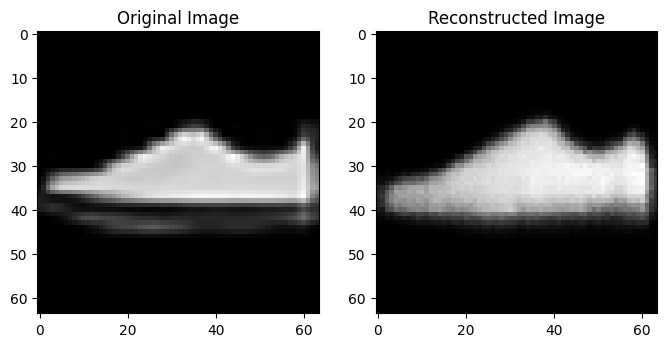

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(img_np[0], cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(reconstructed_img_np[0], cmap='gray')
axes[1].set_title('Reconstructed Image')
plt.show()